In [1]:
#Import necessary packages

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
from __future__ import print_function
from PYME.recipes import modules

from PYME.LMVis import pipeline as pl
from PYME.recipes import tracking,localisations,base;
from PYMEcs.misc.utils import pyme_logging_filter

pyme_logging_filter() # supress a few minor warnings


data = pl.Pipeline("../Biplane QE-PAINT_pig tissue/pig_tissue_biplane_RyR_IP3R_ExchangePAINT.hdf")

In [2]:

data.recipe.update_from_yaml("fiducial_driftcorrection recipe.yaml")                             



print("Current data source: %s" % data.selectedDataSourceKey) # what is the currently selected data source
print("Available data sources: %s" % ', '.join(data.dataSources.keys())) # look at all the data sources we could select

data.selectDataSource('timedSpecies')
print("Number of events in data source timespecies is %d" % data.x.size)

Current data source: filtered_localizations
Available data sources: _Localizations, FitResults, Localizations, colour_mapped, filtered_localizations, Fiducials, fiducialAdded, fiducialApplied, corrected_fiducials, timedSpecies
Number of events in data source timespecies is 465978


/Users/csoe002/Documents/src/PYMEsrc/PYME-extra-py38/PYMEcs/Analysis/trackFiducials.py:154: RuntimeWarning: Mean of empty slice
  mm = np.nanmean(meas, 0)


In [3]:
tb = tracking.FindClumps(inputName='timedSpecies', outputName= 'with_clumps', timeWindow=5)
data.recipe.add_module(tb)
dm = localisations.MergeClumps(inputName='with_clumps', outputName= 'coalesced')
data.recipe.add_module(dm)
data.recipe.execute()

Current data source: coalesced


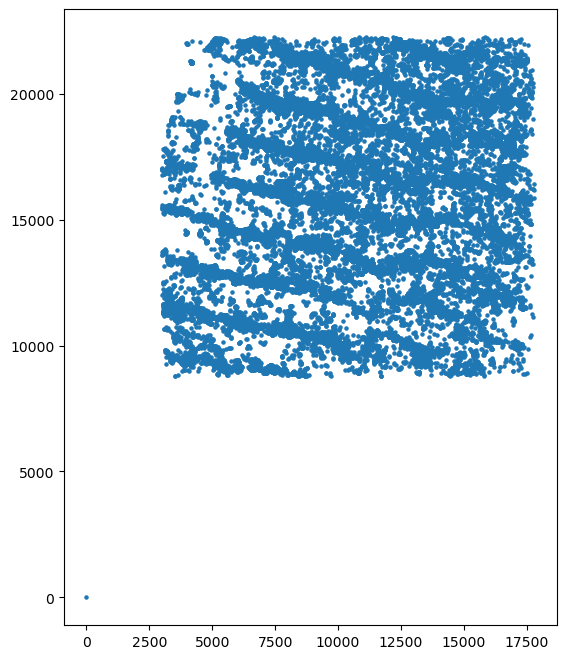

In [4]:
data.selectDataSource('coalesced')
print("Current data source: %s" % data.selectedDataSourceKey) # what is the currently selected data source
plt.subplot(aspect='equal') # we are trying to get the plot aspect ratio to be correct
plt.scatter(data.x,data.y,s=5)